In [7]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, pearsonr
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import read_in_data as rd
from importlib import reload
reload(rd)

mpl.rcParams['figure.dpi'] = 300

GLOFAS_VERSION = 3
STATION = 'glofas_2'

In [8]:
da_glofas_reanalysis = rd.get_glofas_reanalysis(version=GLOFAS_VERSION, station=STATION)
da_glofas_forecast = rd.get_glofas_forecast(version=GLOFAS_VERSION, station=STATION)
da_glofas_forecast_summary = rd.get_da_glofas_summary(da_glofas_forecast)
da_glofas_reforecast = rd.get_glofas_reforecast(version=GLOFAS_VERSION, station=STATION)
da_glofas_reforecast_summary = rd.get_da_glofas_summary(da_glofas_reforecast)

In [ ]:
def basic_plot(da_glofas_reforecast):
    

In [9]:
def is_rainy_season(month):
    # Oct to April
    return (month >= 10) | (month <= 4)

def is_dry_season(month):
    # May to Sept
    return (month < 10) & (month > 4)

def get_skill(da_glofas_reforecast, da_glofas_reanalysis):
    
    df_crps = pd.DataFrame(columns=['leadtime', 'crps'])

    for leadtime in da_glofas_reforecast.leadtime:
        forecast = da_glofas_reforecast.sel(
            leadtime=leadtime.values).dropna(dim='time')
        observations = da_glofas_reanalysis.reindex({'time': forecast.time})
        # For all dates
        crps = xs.crps_ensemble(observations, forecast,member_dim='number')
        # For rainy season only
        observations_rainy = observations.sel(time=is_rainy_season(observations['time.month']))
        crps_rainy = xs.crps_ensemble(
            observations_rainy,
            forecast.sel(time=is_rainy_season(forecast['time.month'])),
            member_dim='number')
        # Dry season only
        observations_dry = observations.sel(time=is_dry_season(observations['time.month']))
        crps_dry = xs.crps_ensemble(
            observations_dry,
            forecast.sel(time=is_dry_season(forecast['time.month'])),
            member_dim='number')
        # Total summary
        df_crps = df_crps.append([{'leadtime': leadtime.values,
                                  'crps': crps.values,
                                   'std': observations.std().values,
                                   'mean': observations.mean().values,
                                  'crps_rainy': crps_rainy.values,
                                   'std_rainy': observations_rainy.std().values,
                                   'mean_rainy': observations_rainy.mean().values,
                                    'crps_dry': crps_dry.values,
                                   'std_dry': observations_dry.std().values,
                                   'mean_dry': observations_dry.mean().values
                                  }], ignore_index=True)
    return df_crps

In [10]:
def plot_skill(df_crps, division_key=None, add_line_from_website=False,
              ylabel="CRPS [m$^3$ s$^{-1}$]"):
    fig, ax = plt.subplots()
    df = df_crps.copy()
    for i, subset in enumerate([None, 'rainy', 'dry']):
        ykey = f'crps_{subset}' if subset is not None else 'crps'
        y = df[ykey]
        if division_key is not None:
            dkey = f'{division_key}_{subset}' if subset is not None else division_key
            y /= df[dkey]
        ax.plot(df['leadtime'], y, ls='-', c=f'C{i}')
    #ax.plot([], [], ls=ls, c='k', label=f'version {version}')
    if add_line_from_website:
        ax.plot(df_skill[0], df_skill[1], ls='-', c='k', lw=0.5, label='from website')
    # Add colours to legend
    for i, subset in enumerate(['full year', 'rainy', 'dry']):
        ax.plot([], [], c=f'C{i}', label=subset)
    ax.set_title("GloFAS forecast skill in Malawi:\n 1999-2019 reforecast")
    ax.set_xlabel("Lead time (days)")
    ax.set_ylabel(ylabel)
    ax.legend()

In [11]:
df_crps = get_skill(da_glofas_reforecast, da_glofas_reanalysis)

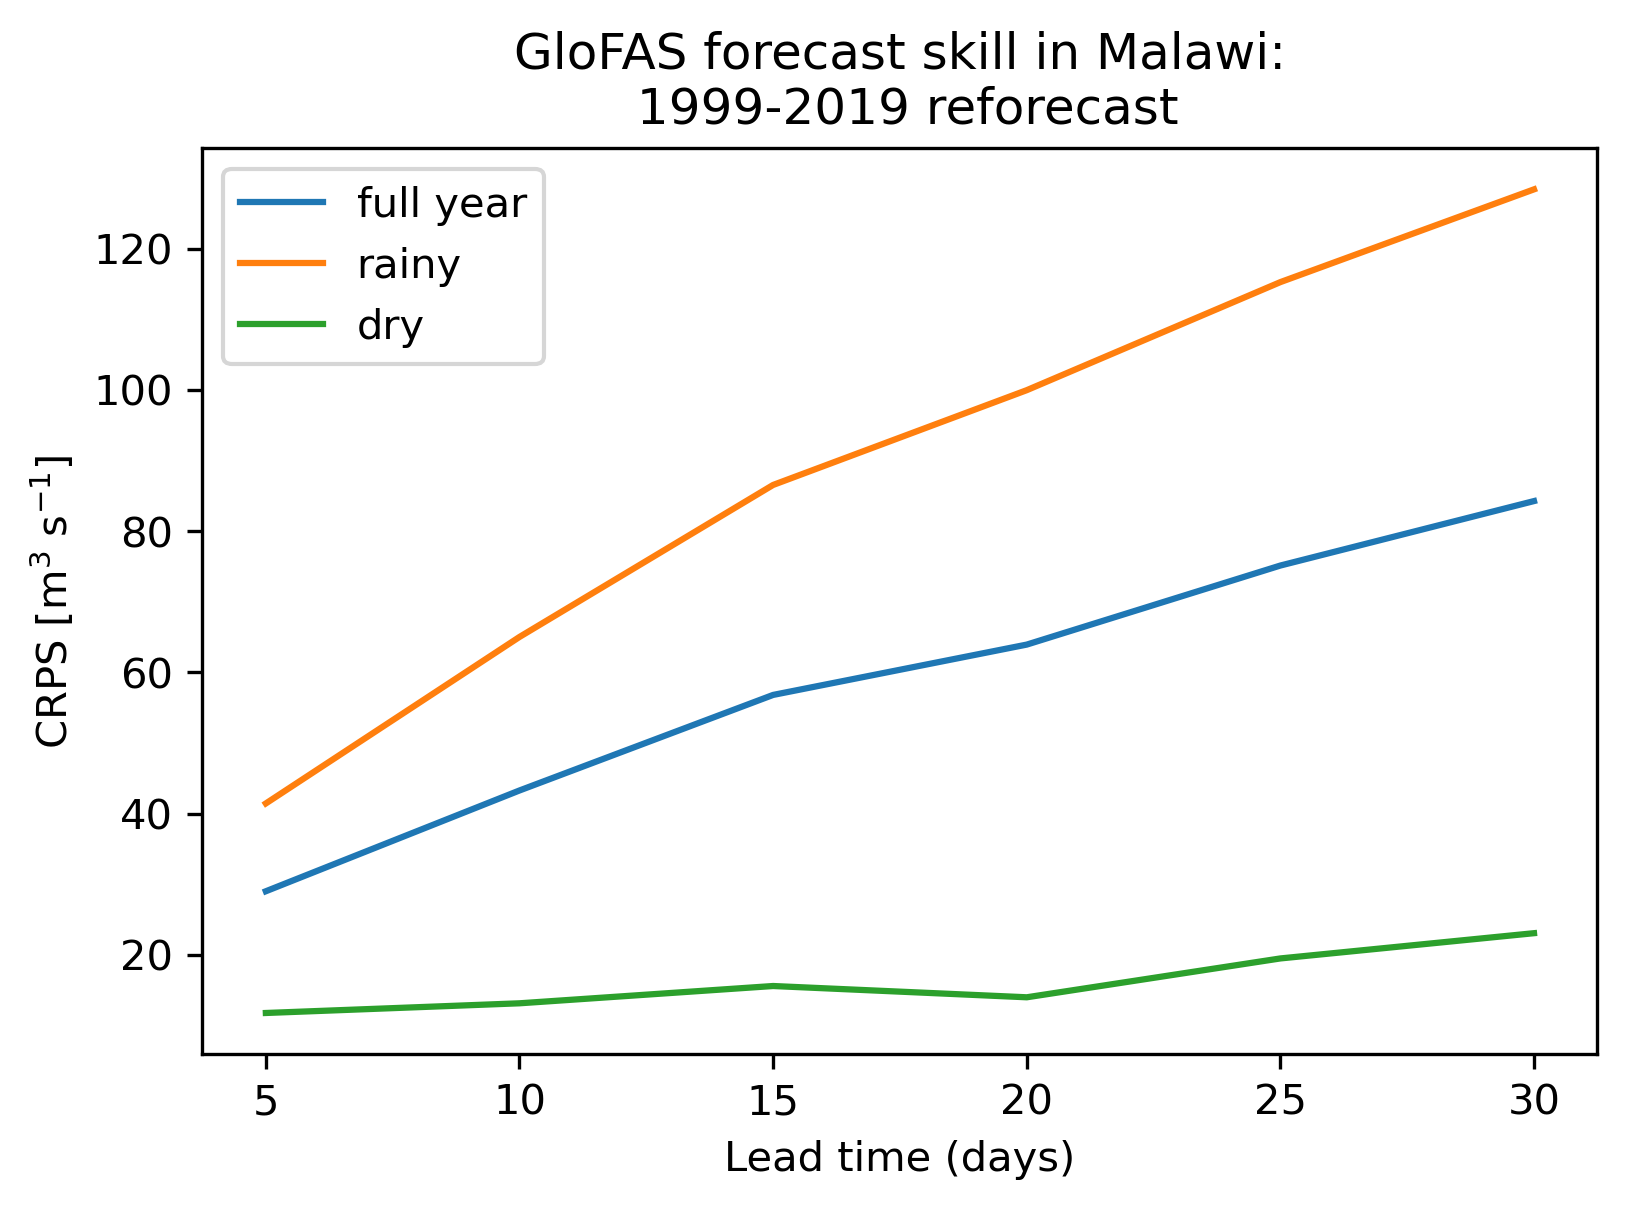

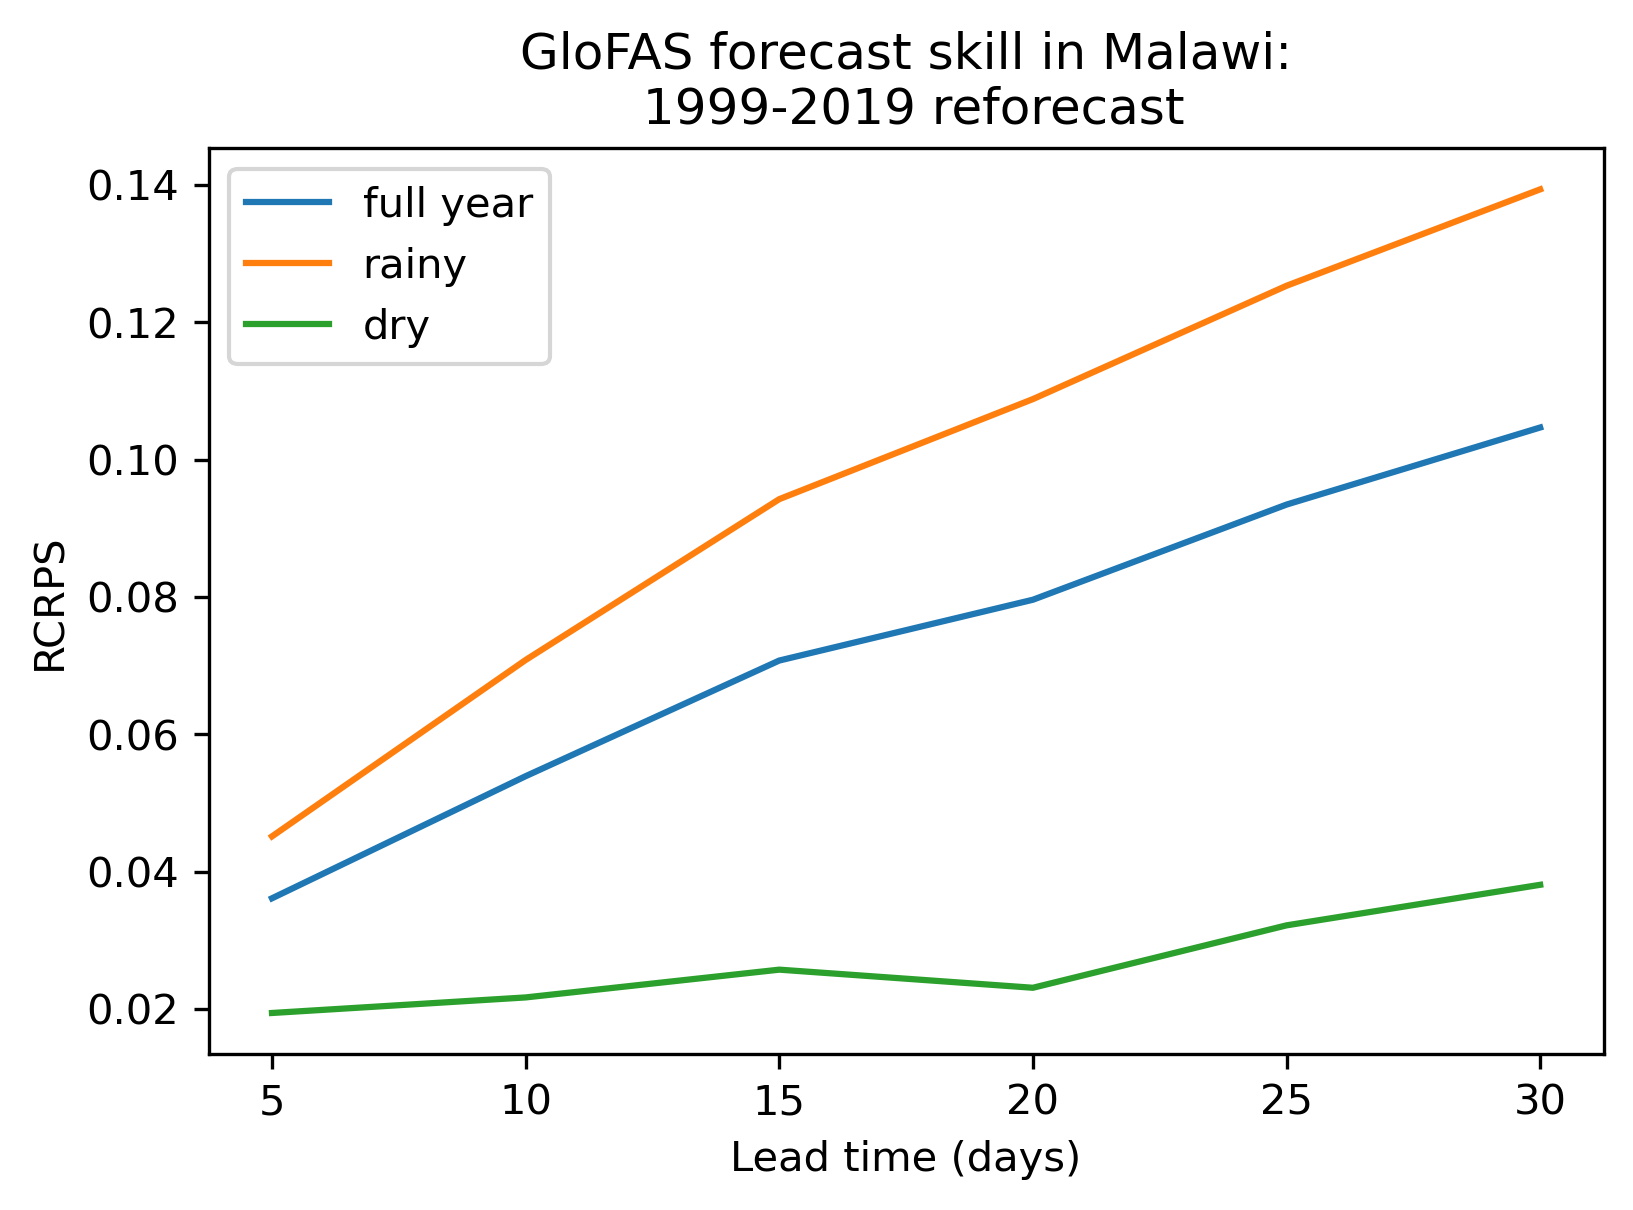

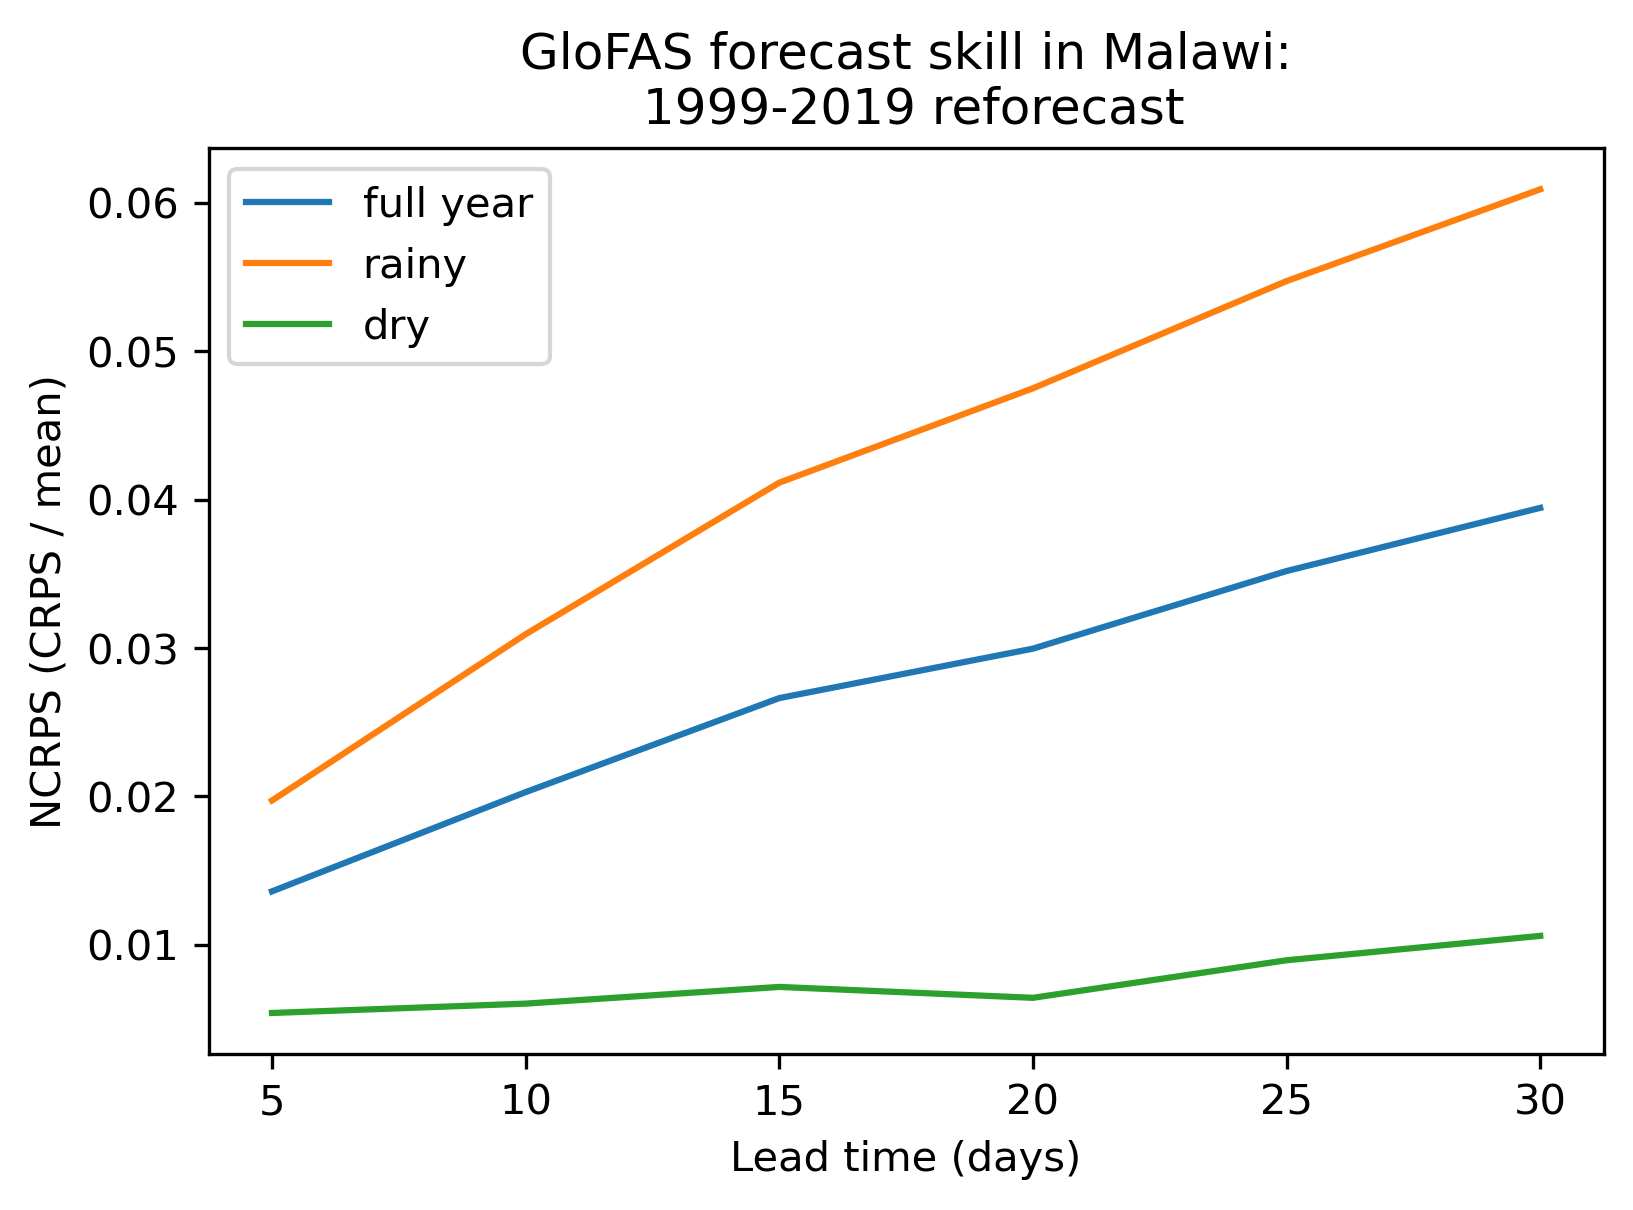

In [12]:
plot_skill(df_crps)

# Rainy season performs the worst, but this is likely because 
# the values during this time period are higher. Try using 
# reduced skill (dividing by standard devation).
plot_skill(df_crps, division_key='std', ylabel="RCRPS")

#This is perhpas not exactly what we want because we know this 
#data comes from the same location and the dataset has the same properties, 
#but we are splitting it up by mean value. Therefore try normalizing using mean
plot_skill(df_crps, division_key='mean', ylabel="NCRPS (CRPS / mean)")